# 線量分布のチェック

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys, os 
sys.path.append("/home/yoshida/workspace/yoshida/study/modules/")
from read_dose.ddreader import *

# Allocation GPU hardware ID = 0
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.set_visible_devices(physical_devices[1], 'GPU')

2023-03-01 14:58:38.767209: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2023-03-01 14:58:40.822909: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-03-01 14:58:40.823929: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2023-03-01 14:58:42.540016: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:02:00.0 name: NVIDIA TITAN V computeCapability: 7.0
coreClock: 1.455GHz coreCount: 80 deviceMemorySize: 11.77GiB deviceMemoryBandwidth: 607.97GiB/s
2023-03-01 14:58:42.540336: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 1 with properties: 
pciBusID: 0000:03:00.0 name: NVIDIA TITAN V computeCapability: 7.0
coreClock: 1.455GHz coreCount: 80 deviceMemorySize: 11.77GiB deviceMemoryBandwidth: 607.97GiB/s
2023-03-01 14:5

In [2]:
dir_name = "data_07" 
theta_s = [i*10 for i in range(36)]
phi = 0

file_names = [str(dir_name)+"/"+str(theta)+","+str(phi)+".csv" for theta in theta_s]

data = [np.array(pd.read_csv(file_name)['dose']).reshape(61,61,150) for file_name in file_names]

data = np.array(data).astype("float32")
data = np.expand_dims(data, axis=4)

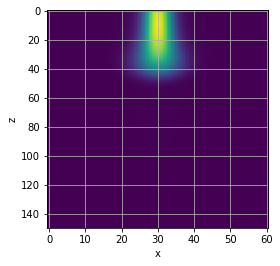

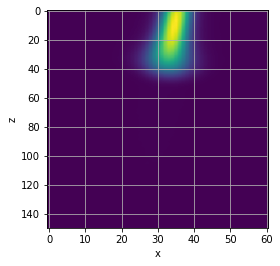

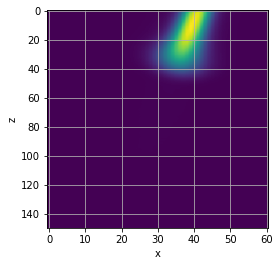

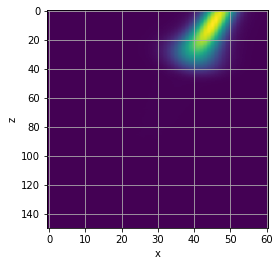

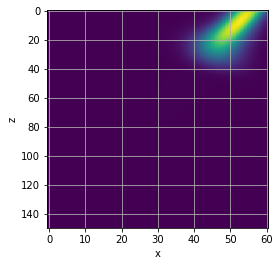

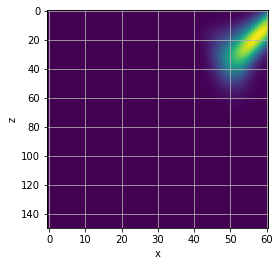

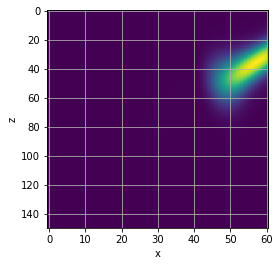

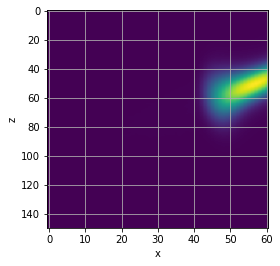

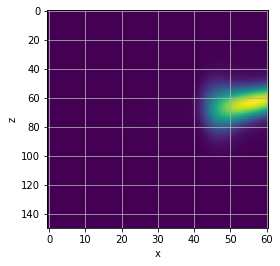

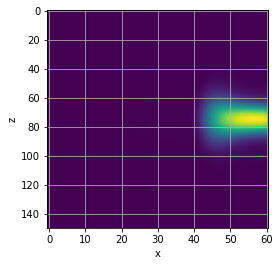

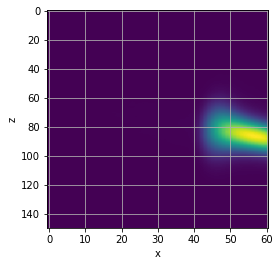

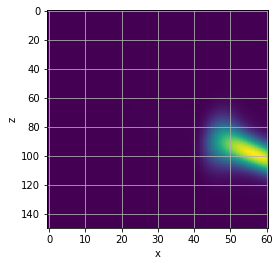

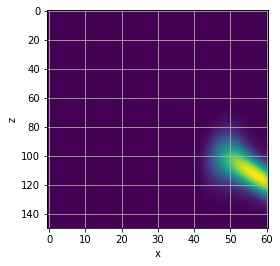

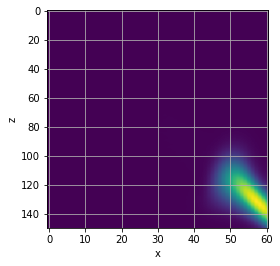

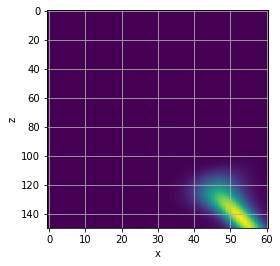

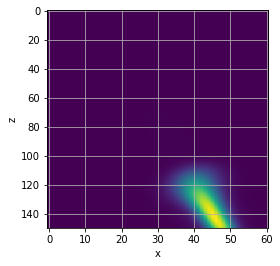

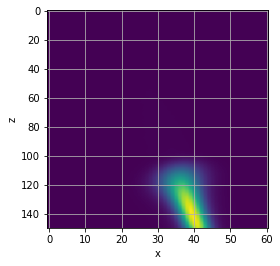

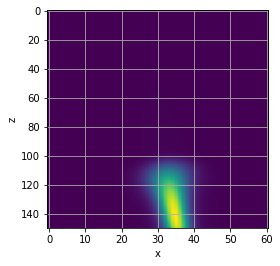

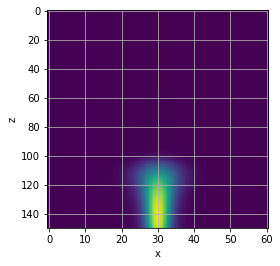

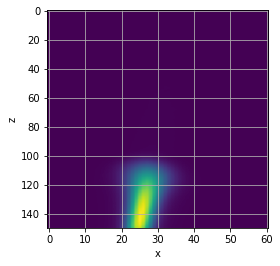

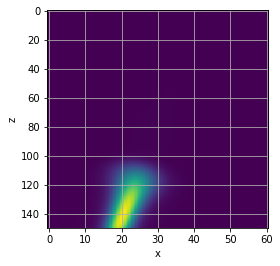

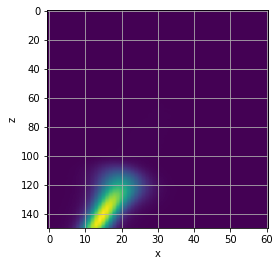

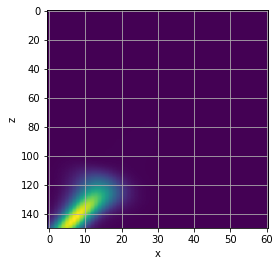

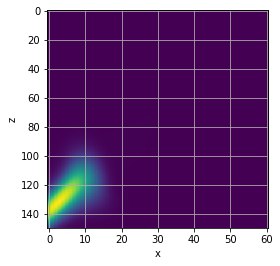

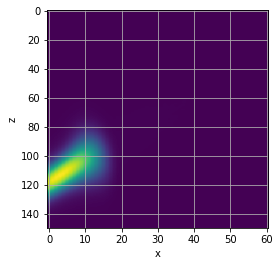

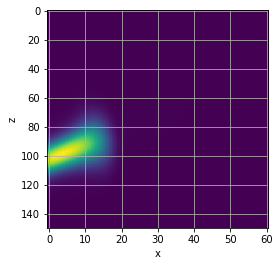

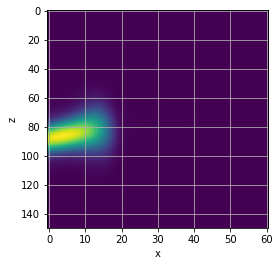

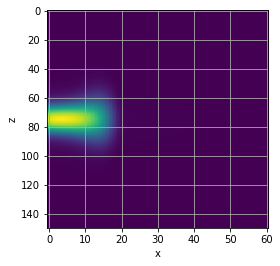

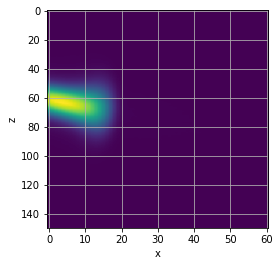

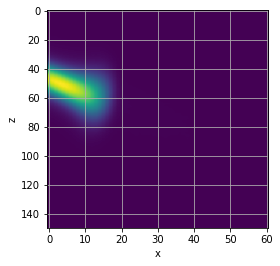

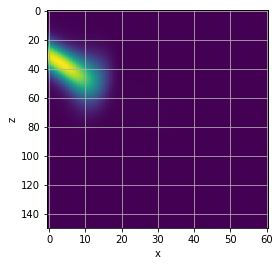

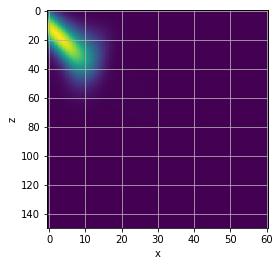

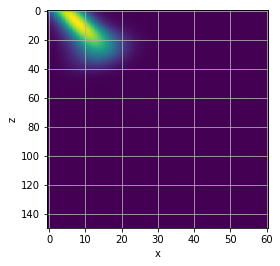

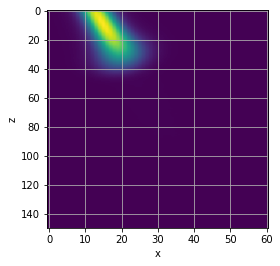

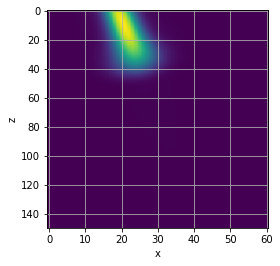

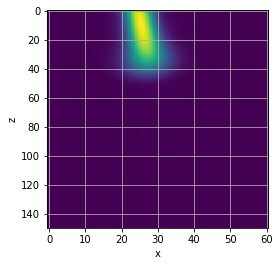

In [3]:
for i in range(36):
    dd_test = data[i]
    
    plt.imshow(dd_test.reshape(150,61,61).sum(2), aspect=0.4)
    plt.ylabel("z")
    plt.xlabel("x")
    plt.grid()
    plt.show()
    plt.close()

## 前回と同様のネットワークを作成

In [4]:
#Input shape の定義
inp_shape = (61, 61, 150, 1)
inputs = tf.keras.Input(shape = inp_shape)

# x = layer()(x)の形で層を定義していく
x = tf.keras.layers.Conv3D(16, 2, activation = 'relu', strides = 2, name = "conv3d_1")(inputs)
x = tf.keras.layers.BatchNormalization(name = "normalize_1")(x)

x = tf.keras.layers.Conv3D(32, 2, activation = 'relu', strides = 2, name = "conv3d_2")(x)
x = tf.keras.layers.BatchNormalization(name = "normalize_2")(x)

x = tf.keras.layers.Conv3D(64, 2, activation = 'relu', strides = 2, name = "conv3d_3")(x)

x = tf.keras.layers.Flatten(name = "flatten")(x)

# 出力層を複数にする場合は、出力層 = layer()(中間層)の形にする。
theta = tf.keras.layers.Dense(360, activation='softmax', name = "theta")(x)
# phi = tf.keras.layers.Dense(91, activation='softmax'  , name = "phi"  )(x)

#ここで、modelのinputとoutputを定義する
model = tf.keras.Model(inputs=inputs, outputs= theta)

#出力層ごとにoptimizerやlossを変更できるが、全て同じで良い場合はひとつ設定すれば良い
model.compile(loss      = tf.keras.losses.BinaryCrossentropy(),
              optimizer = tf.keras.optimizers.SGD(0.2))

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 61, 61, 150, 1)]  0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 30, 30, 75, 16)    144       
_________________________________________________________________
normalize_1 (BatchNormalizat (None, 30, 30, 75, 16)    64        
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 15, 15, 37, 32)    4128      
_________________________________________________________________
normalize_2 (BatchNormalizat (None, 15, 15, 37, 32)    128       
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 7, 7, 18, 64)      16448     
_________________________________________________________________
flatten (Flatten)            (None, 56448)             0     

2023-03-01 14:58:57.040434: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-01 14:58:57.044765: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:03:00.0 name: NVIDIA TITAN V computeCapability: 7.0
coreClock: 1.455GHz coreCount: 80 deviceMemorySize: 11.77GiB deviceMemoryBandwidth: 607.97GiB/s
2023-03-01 14:58:57.044817: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2023-03-01 14:58:57.044883: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2023-03-01 14:58:57.044925: I tensorflow/stream_executor/platform/default/dso_

In [5]:
dir_name = "data_07" 
theta_s = [5 * i for i in range(72)]
phi = 0

file_names = [str(dir_name)+"/"+str(theta)+","+str(phi)+".csv" for theta in theta_s]

data = [np.array(pd.read_csv(file_name)['dose']).reshape(61,61,150) for file_name in file_names]

data = np.array(data).astype("float32")
data = np.expand_dims(data, axis=4)

label = np.zeros((72,360))
for j in range(72):
    label[j][5 * j] = 0.5

## 学習

In [6]:
for nums in range(100):
    itr = np.random.randint(0, len(data), [128,2])
    
    x_train = np.array([data[i[0]] + data[i[1]] for i in itr])
    
    t_train = np.array([label[i[0]] + label[i[1]] for i in itr])

    model.fit(x = x_train, y = t_train,
          batch_size = 2**13,
          epochs     = 20)
    print(nums)

2023-03-01 14:59:13.552323: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2023-03-01 14:59:13.564582: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3100015000 Hz


Epoch 1/20


2023-03-01 14:59:14.223718: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2023-03-01 14:59:14.659650: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7
2023-03-01 14:59:15.647173: W tensorflow/stream_executor/gpu/asm_compiler.cc:63] Running ptxas --version returned 256
2023-03-01 14:59:15.694188: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: ptxas exited with non-zero error code 256, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


1/1 [==============================] - 3s 3s/step - loss: 0.7736
Epoch 2/20
1/1 [==============================] - 0s 174ms/step - loss: 0.3031
Epoch 3/20
1/1 [==============================] - 0s 170ms/step - loss: 0.1729
Epoch 4/20
1/1 [==============================] - 0s 171ms/step - loss: 0.1146
Epoch 5/20
1/1 [==============================] - 0s 171ms/step - loss: 0.0834
Epoch 6/20
1/1 [==============================] - 0s 171ms/step - loss: 0.0650
Epoch 7/20
1/1 [==============================] - 0s 171ms/step - loss: 0.0532
Epoch 8/20
1/1 [==============================] - 0s 170ms/step - loss: 0.0452
Epoch 9/20
1/1 [==============================] - 0s 170ms/step - loss: 0.0395
Epoch 10/20
1/1 [==============================] - 0s 171ms/step - loss: 0.0352
Epoch 11/20
1/1 [==============================] - 0s 170ms/step - loss: 0.0319
Epoch 12/20
1/1 [==============================] - 0s 171ms/step - loss: 0.0293
Epoch 13/20
1/1 [==============================] - 0s 170ms/ste

In [11]:
dir_name = str("data_07") 
theta_s = [i for i in range(360)]
phi = 0

file_names = [str(dir_name)+"/"+str(theta)+","+str(phi)+".csv" for theta in theta_s]

## 推論

In [13]:
data = [np.array(pd.read_csv(file_name)['dose']).reshape(61,61,150) for file_name in file_names]

data = np.array(data).astype("float32")
data = np.expand_dims(data, axis=4)

In [14]:
label = np.zeros((360,360))
for j in range(360):
    label[j][j] = 0.5

In [15]:
itr = np.random.randint(0, len(data), [100,2])

x_test = np.array([data[i[0]] + data[i[1]] for i in itr])

t_test = np.array([label[i[0]] + label[i[1]] for i in itr])    

In [16]:
t_pred = model.predict(x_test)

In [17]:
t_pred_idx = t_pred[0].argsort()[::-1]

In [18]:
pred = []
for i in range(100):
    t_pred_idx = t_pred[i].argsort()[::-1]
    pred.append([t_pred_idx[0], t_pred_idx[1]])
pred = np.array(pred)

In [19]:
print(itr.sort())

None


In [20]:
print(pred.sort())

None


In [21]:
diff = pred - itr

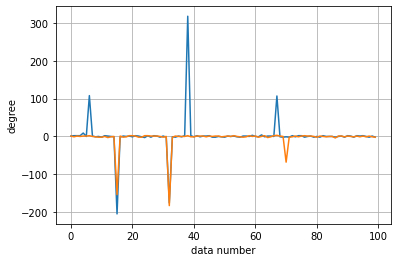

In [24]:
plt.plot(diff)
plt.ylabel("degree")
plt.xlabel("data number")

plt.grid()
plt.savefig("/home/yoshida/workspace/yoshida/study/predict_two_direc.png")

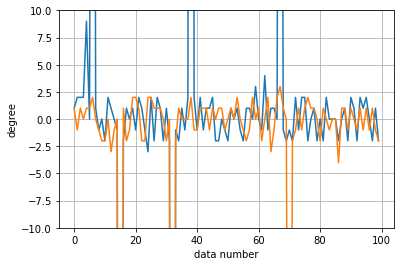

In [25]:
plt.plot(diff)
plt.ylabel("degree")
plt.xlabel("data number")
plt.ylim(-10,10)
plt.grid()
plt.savefig("/home/yoshida/workspace/yoshida/study/predict_two_direc_up.png")

前回の照射条件と比較して(間違えていたもの)、見分けがつきやすい（感想）ためか、推論がよく合っている。

一部でおおきくはずれている部分がある。実際の値を見てみると

In [76]:
print(diff)

[[   1    1]
 [   0    3]
 [  -2   -1]
 [   2    1]
 [  -2    0]
 [   0    0]
 [   2   -2]
 [   1    2]
 [   1    1]
 [  -1    2]
 [  -2    3]
 [  -1   -1]
 [  -2   -1]
 [   2    2]
 [   2    2]
 [   1    1]
 [  -1    0]
 [   4   -2]
 [   0   -2]
 [   1    2]
 [   0    2]
 [   2   -3]
 [   1    1]
 [  -2    2]
 [  -1    3]
 [   3    0]
 [  -2    0]
 [  -2    0]
 [   0   -1]
 [   2   -1]
 [   1    0]
 [   0    1]
 [  -2   -2]
 [   2   -2]
 [   1   -1]
 [  -1   -2]
 [  -2    2]
 [   1    1]
 [  -1   -2]
 [   0    1]
 [  -1    1]
 [   0   -1]
 [  -2    0]
 [   1    3]
 [  -1    2]
 [   1   -2]
 [ 143    2]
 [   1   -1]
 [   2   -1]
 [  -2    0]
 [  -1    0]
 [   2    0]
 [   1    0]
 [  -3    0]
 [  -1    0]
 [  -1   -1]
 [  -1    0]
 [  -1    0]
 [   2   -1]
 [  -2    0]
 [  -2   -1]
 [   1   -1]
 [   1    0]
 [  -2    0]
 [   1   -1]
 [  -2   -2]
 [  -1    2]
 [  -2    0]
 [   1    0]
 [   1    0]
 [  -1   -2]
 [  -1   -1]
 [  -1    1]
 [-154 -202]
 [   1    0]
 [   1   -2]
 [  -1   -1]

[  0 300]
[298 358]


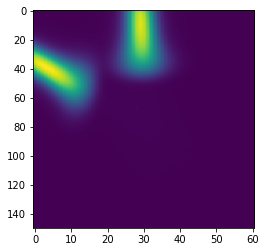

In [87]:
plt.imshow(x_test[96].reshape(150,61,61).sum(2), aspect=0.4)
print(pred[96])
print(itr[96])

[  0 155]
[154 357]


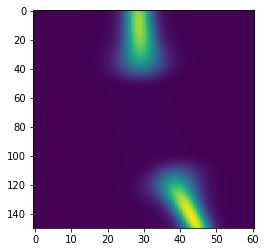

In [92]:
plt.imshow(x_test[73].reshape(150,61,61).sum(2), aspect=0.4)
print(pred[73])
print(itr[73])

360と0の場合にdiffの値が異常に大きくなっている。評価の方法については考える必要がある。

依然として、第二候補に第一候補と同じ角度が現れる場合もある。

[15 20]
[17 47]


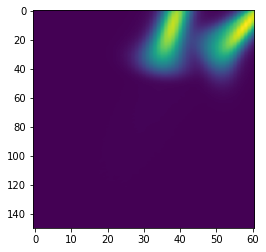

In [93]:
plt.imshow(x_test[81].reshape(150,61,61).sum(2), aspect=0.4)
print(pred[81])
print(itr[81])

[225 230]
[ 82 228]


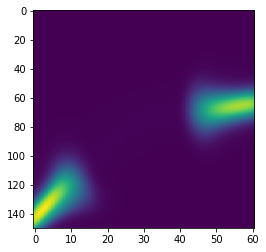

In [99]:
plt.imshow(x_test[46].reshape(150,61,61).sum(2), aspect=0.4)
print(pred[46])
print(itr[46])

照射の条件をより治療装置に近づける。

具体的には、水ファントムの中心でビームが交差するようにする。